In [ ]:
import os, sys
os.chdir('../')
sys.path.append('../')

In [1]:
import data_handling
from data_specific import *
import model_creating, metrics
import torch, torch.nn as nn
import inference
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
import uncertainty as U
import pandas as pd

In [2]:
from importlib import reload

In [3]:
df = pd.read_csv('/mnt/tank/scratch/tpolevaya/dis_ds.csv')

In [4]:
df

,Name,augm,datasets,save_folder
0,"hflip,saturation,cutout bs=50 lr=0.0001","hflip,saturation,cutout","dermnet,hellenic,dermnetnz",logs/weights/run_20210614_134931
1,"hflip,saturation,cutout bs=50 lr=0.0001","hflip,saturation,cutout","dermnet,gsa",logs/weights/run_20210614_122929
2,"hflip,saturation,cutout bs=50 lr=0.0001","hflip,saturation,cutout","gsa,dermis,atlas_derm,hellenic,dermnetnz",logs/weights/run_20210614_083858
3,"hflip,saturation,cutout bs=50 lr=0.0001","hflip,saturation,cutout","dermnet,atlas_derm",logs/weights/run_20210614_083507
4,"hflip,saturation,cutout bs=50 lr=0.0001","hflip,saturation,cutout","dermnet,dermis",logs/weights/run_20210613_233526


In [5]:
# def get_remaining_datasets(trn_datasets):
#     ds = data_handling.get_ds_names(True,False) + data_handling.get_ds_names(False,False)
#     ds = set(ds).difference(set(trn_datasets))
#     return sorted(ds)

In [6]:
# datasets = df.iloc[0].datasets.split(',')
augm = df.iloc[0].augm

In [7]:
primary = np.array(['пятно+эритема', 'бугорок', 'узел', 'папула+бляшка+комедон', 'волдырь', 'пузырек', 'пузырь', 'гнойничок'])
diseases = np.array(['атопический дерматит', 'акне', 'псориаз', 'розацеа', 'бородавки', 'герпес', 'красный полский лишай', 'витилиго', 'аллергический контактный дерматит', 'экзема', 'дерматомикозы', 'буллезный пемфигоид', 'пузырчатка', 'контагиозный моллск', 'крапивница', 'себорейный кератоз', 'чесотка', 'себорейный дерматит', 'актинический кератоз', 'базалиома'])

In [8]:
all_ds_names = 'chicago,dermnet,dermis,iowa,gsa,ulb,atlas_derm,hellenic,dermnetnz'.split(',')

In [9]:
eval_ds_names = ['dermnetnz']

In [11]:
device = torch.device(f'cuda:1')
data = Data.Diseases
class_mode = get_class_mode(data)

In [12]:
base_ds = data_handling.create_total_ds(eval_ds_names, get_ds_class(data), 448)

creating dataset from:  dermnetnz


  0%|          | 0/1710 [00:00<?, ?it/s]

In [13]:
vanilla_dl = DataLoader(data_handling.AugmDataset(base_ds, None), batch_size=100, shuffle=False)
augm_dl = DataLoader(data_handling.AugmDataset(base_ds, augm), batch_size=100, shuffle=False)

In [14]:
def print_acc(preds, lbls):
    print(f'accuracy = {sklearn.metrics.accuracy_score(lbls, preds):.4f}')

In [15]:
def plot_cfm(preds, lbls):
    cfm = sklearn.metrics.confusion_matrix(lbls, preds)
    cfm_by_true = cfm.sum(axis=-1, keepdims=True)
    fig, ax = plt.subplots(figsize=(24,24))   
    sns.heatmap(cfm/cfm_by_true, annot=True, cmap='Blues', ax=ax)

## Evaluate one model

In [16]:
models = [model_creating.load_model(df.iloc[idx].save_folder, get_num_classes(data), device) for idx in range(5)]

### Vanilla

In [17]:
probs, lbls = inference.predict(device, vanilla_dl, models[3], class_mode)
preds = probs.argmax(axis=-1)
print_acc(preds, lbls)

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

accuracy = 0.3544


In [18]:
probs, lbls = inference.predict(device, vanilla_dl, models[1], class_mode)
preds = probs.argmax(axis=-1)
print_acc(preds, lbls)

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

accuracy = 0.3813


In [19]:
probs, lbls = inference.predict(device, vanilla_dl, models[4], class_mode)
preds = probs.argmax(axis=-1)
print_acc(preds, lbls)

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

accuracy = 0.3924


In [20]:
all_probs, all_lbls = inference.predict_ensemble(device, vanilla_dl, [models[3], models[4]], class_mode)
exp_probs = U.get_expected(all_probs)
preds = exp_probs.argmax(axis=-1)
lbls = all_lbls[0]
print_acc(preds, lbls)

Model:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

accuracy = 0.4094


In [17]:
all_probs, all_lbls = inference.predict_ensemble(device, vanilla_dl, [models[3], models[1], models[4]], class_mode)
exp_probs = U.get_expected(all_probs)
preds = exp_probs.argmax(axis=-1)
lbls = all_lbls[0]
print_acc(preds, lbls)

Model:   0%|          | 0/3 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

accuracy = 0.4298


#### cfm

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


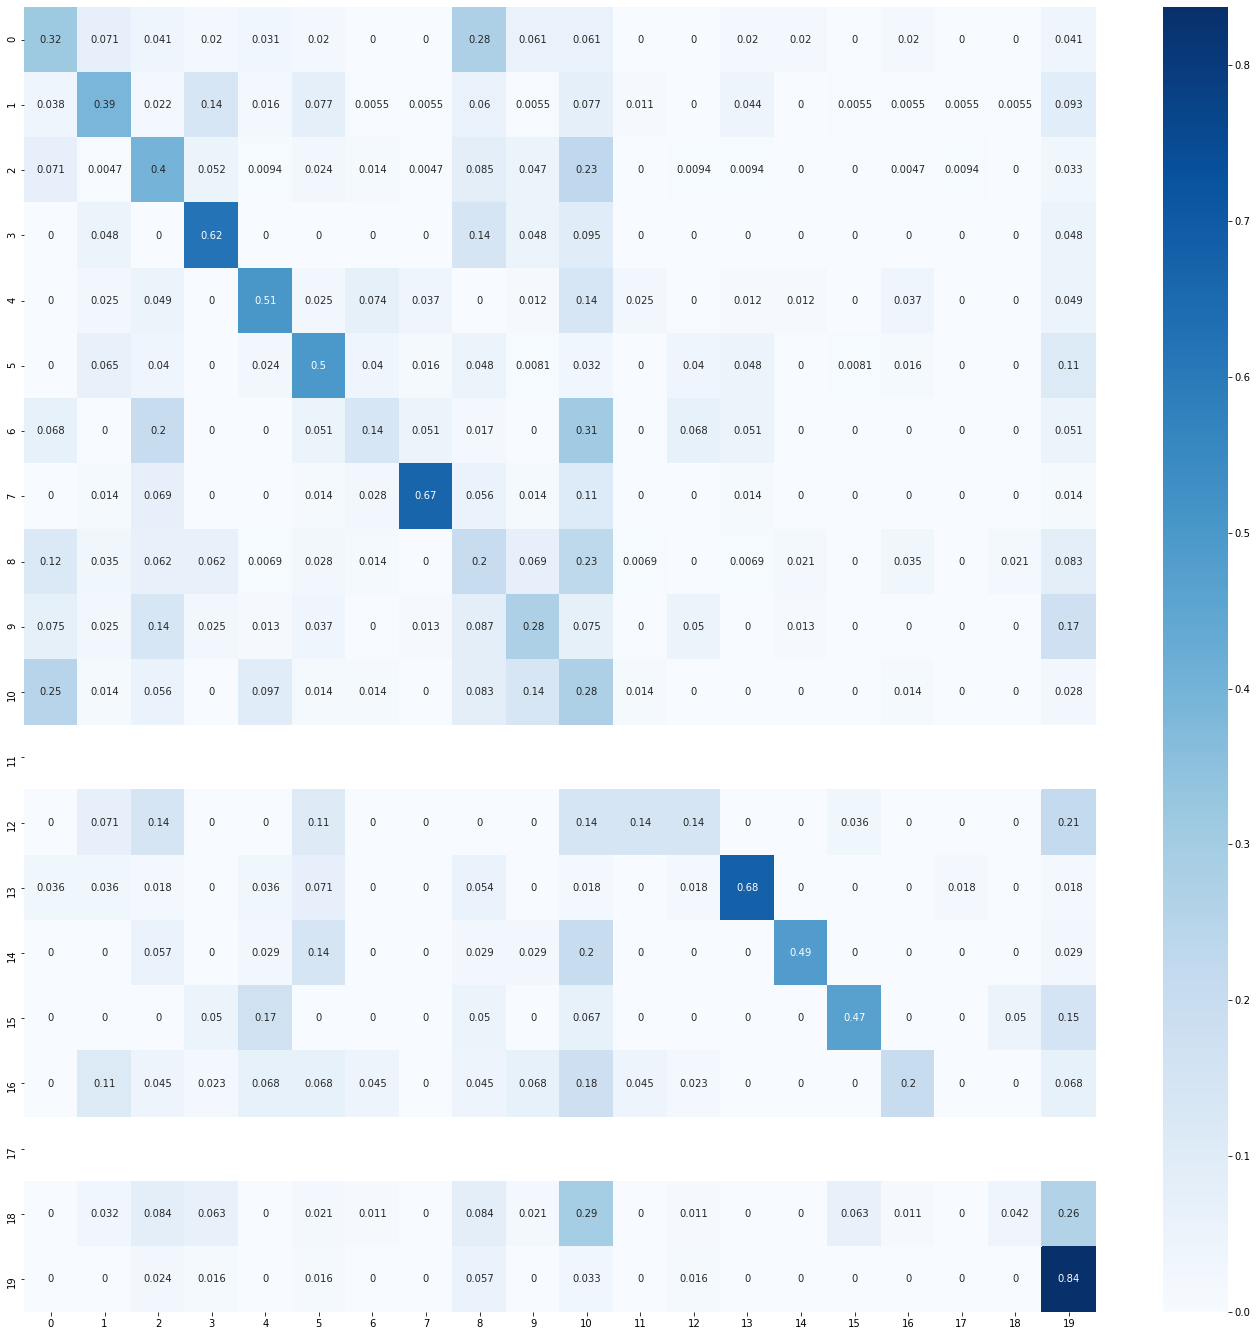

In [18]:
plot_cfm(preds, lbls)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


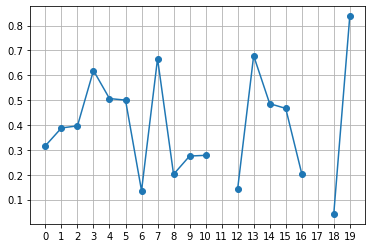

In [19]:
cfm = sklearn.metrics.confusion_matrix(lbls, preds)
cfm_by_true = cfm.sum(axis=-1, keepdims=True)
cfm = cfm/cfm_by_true
N = cfm.shape[0]

plt.plot([cfm[i][i] for i in range(cfm.shape[0])], marker='o')
plt.xticks(list(range(N)))
plt.grid()

In [20]:
for m in models: m.to(torch.device('cpu'))

In [21]:
torch.cuda.empty_cache()

In [22]:
[cfm[i][i] for i in range(cfm.shape[0])]

[0.3163265306122449,
 0.3879781420765027,
 0.39622641509433965,
 0.6190476190476191,
 0.5061728395061729,
 0.5,
 0.13559322033898305,
 0.6666666666666666,
 0.2013888888888889,
 0.275,
 0.2777777777777778,
 nan,
 0.14285714285714285,
 0.6785714285714286,
 0.4857142857142857,
 0.4666666666666667,
 0.20454545454545456,
 nan,
 0.042105263157894736,
 0.8373983739837398]

In [ ]:
0.3163265306122449
0.3879781420765027
0.39622641509433965
0.6190476190476191
0.5061728395061729
0.5
0.13559322033898305
0.6666666666666666
0.2013888888888889
0.275
0.2777777777777778
nan
0.14285714285714285
0.6785714285714286
0.4857142857142857
0.4666666666666667
0.20454545454545456
nan
0.042105263157894736
0.8373983739837398

### With TTA

In [23]:
for m in models: m.to(torch.device(device))

In [26]:
all_probs, all_lbls = inference.predict_ensemble_TTA(device, augm_dl, [models[3], models[1], models[4]], class_mode, num_augm=2)

Model:   0%|          | 0/3 [00:00<?, ?it/s]

Augm:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Augm:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Augm:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

Inference:   0%|          | 0/18 [00:00<?, ?it/s]

In [27]:
exp_probs = U.get_expected(all_probs)
preds = exp_probs.argmax(axis=-1)
lbls = all_lbls[0]

In [28]:
print_acc(preds, lbls)

accuracy = 0.4269


#### cfm

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


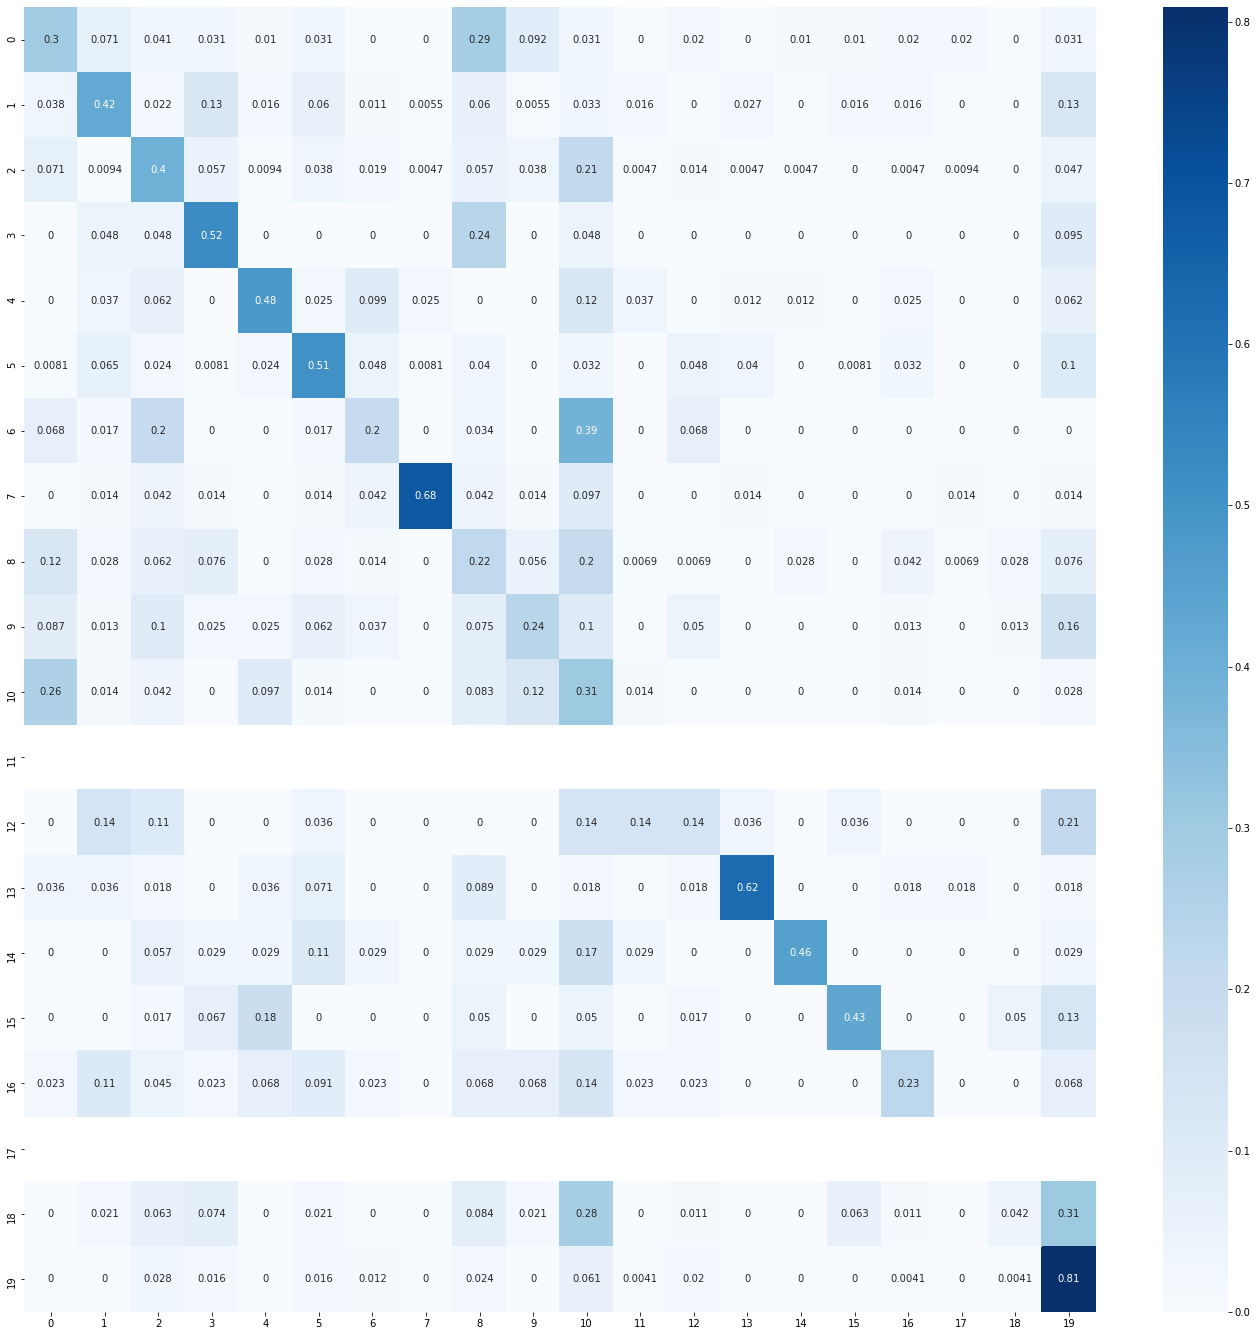

In [29]:
plot_cfm(preds, lbls)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


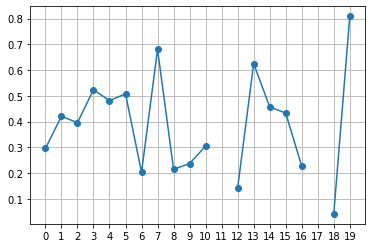

In [30]:
cfm = sklearn.metrics.confusion_matrix(lbls, preds)
cfm_by_true = cfm.sum(axis=-1, keepdims=True)
cfm = cfm/cfm_by_true
N = cfm.shape[0]

plt.plot([cfm[i][i] for i in range(cfm.shape[0])], marker='o')
plt.xticks(list(range(N)))
plt.grid()

In [31]:
[cfm[i][i] for i in range(cfm.shape[0])]

[0.29591836734693877,
 0.4207650273224044,
 0.39622641509433965,
 0.5238095238095238,
 0.48148148148148145,
 0.5080645161290323,
 0.2033898305084746,
 0.6805555555555556,
 0.2152777777777778,
 0.2375,
 0.3055555555555556,
 nan,
 0.14285714285714285,
 0.625,
 0.45714285714285713,
 0.43333333333333335,
 0.22727272727272727,
 nan,
 0.042105263157894736,
 0.8089430894308943]

In [ ]:
0.29591836734693877
0.4207650273224044
0.39622641509433965
0.5238095238095238
0.48148148148148145
0.5080645161290323
0.2033898305084746
0.6805555555555556
0.2152777777777778
0.2375
0.3055555555555556
nan
0.14285714285714285
0.625
0.45714285714285713
0.43333333333333335
0.22727272727272727
nan
0.042105263157894736
0.8089430894308943

#### Uncertainty

In [58]:
totalU, dataU, knowU = U.get_uncertainties(all_probs, all_lbls)

/mnt/tank/scratch/tpolevaya/miniconda3/envs/derm-dis-morph/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


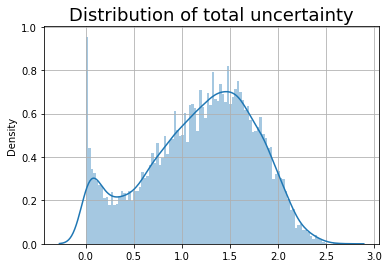

In [59]:
U.plot_totalU(totalU)